In [10]:
import pandas as pd

df= pd.read_csv(r"preprocessed.csv")


In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


In [12]:
df.drop(["Unnamed: 0","index","cluster_changed",'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality','cluster','rul'], axis=1, inplace=True)


In [13]:
# Define the start and end times as lists
start_times = ['2022-02-27 00:00:00', '2022-03-22 00:00:00', '2022-05-29 00:00:00']
end_times = ['2022-03-02 00:00:00', '2022-03-25 02:00:00', '2022-06-04 00:00:00']

# Convert start and end times to datetime
start_times = [pd.to_datetime(time) for time in start_times]
end_times = [pd.to_datetime(time) for time in end_times]

# Filter the DataFrame using a loop
filtered_dfs = []
for start_time, end_time in zip(start_times, end_times):
    filtered_dfs.append(df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)])


In [14]:
filtered_dfs[0].columns

Index(['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
       'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG',
       'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses', 'timestamp',
       'rul'],
      dtype='object')

In [19]:
# Merge all DataFrames in merged_chunks into a single DataFrame
df = pd.concat(filtered_dfs, ignore_index=True)

# Check the result
print(f"Final DataFrame has {len(df)} rows.")


Final DataFrame has 727512 rows.


In [46]:
import pandas as pd

# Define the start and end times as lists
start_times = ['2022-02-28 21:53:00', '2022-03-23 14:54:00', '2022-05-30 12:00:00']
end_times = ['2022-03-01 02:00:00', '2022-03-23 15:24:00', '2022-06-02 06:18:00']

# Convert start and end times to datetime
start_times = [pd.to_datetime(time) for time in start_times]
end_times = [pd.to_datetime(time) for time in end_times]

# Initialize the fault and fault_id columns to 0
df['fault'] = 0
df['fault_id'] = 0

# Loop through the start and end times to check the conditions
for i, (start, end) in enumerate(zip(start_times, end_times), start=1):
    mask = (df['timestamp'] >= start) & (df['timestamp'] <= end)
    df.loc[mask, 'fault'] = 1
    df.loc[mask, 'fault_id'] = i  # Assign fault_id based on the loop index

# Ensure fault column is integer type
df['fault'] = df['fault'].astype(int)


In [47]:
df.columns

Index(['TP2', 'TP3', 'H1', 'Reservoirs', 'Oil_temperature', 'Flowmeter',
       'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS',
       'Caudal_impulses', 'timestamp', 'fault', 'fault_id'],
      dtype='object')

In [48]:
df['fault_id'].value_counts()

fault_id
0    727512
Name: count, dtype: int64

In [49]:
df['fault'].value_counts()

fault
0    515406
1    212106
Name: count, dtype: int64

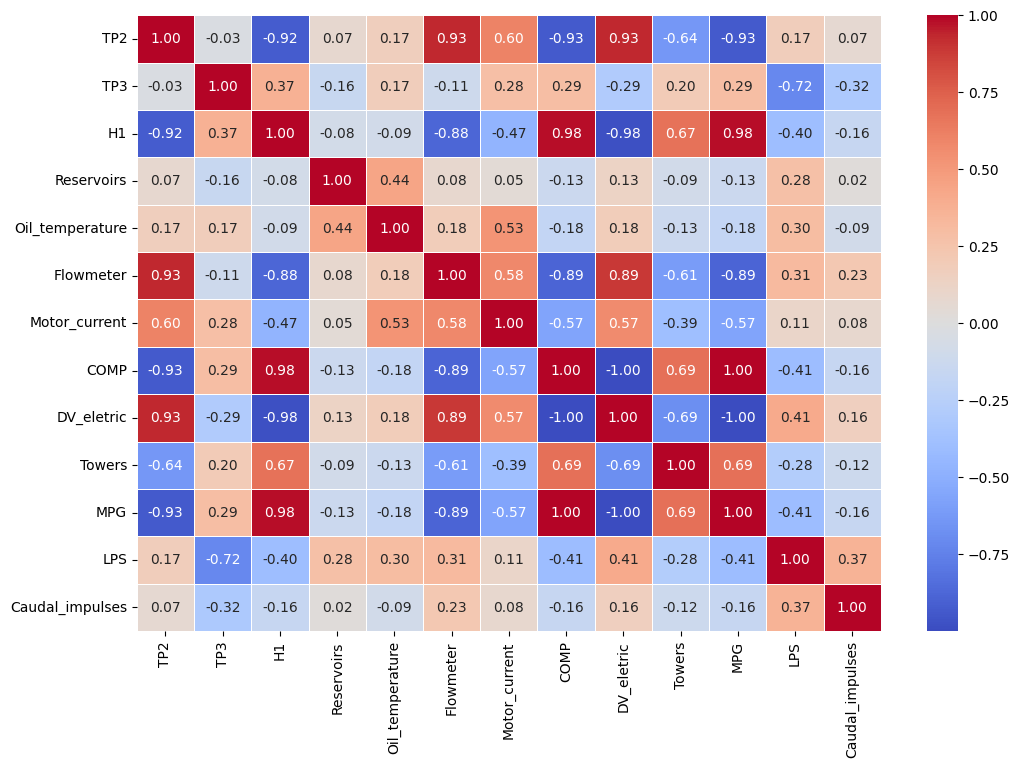

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the 'timestamp' and 'orr' columns
df_filtered = df.drop(columns=['timestamp', 'fault','fault_id'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.show()


In [31]:
df['Pressure_switch'].value_counts()

(Pressure_switch
 0    727512
 Name: count, dtype: int64,)

In [32]:
df['Oil_level'].value_counts()

Oil_level
0    727512
Name: count, dtype: int64

In [33]:
df.drop(['Pressure_switch','Oil_level','DV_pressure'], axis=1, inplace=True)


In [50]:
df.columns

Index(['TP2', 'TP3', 'H1', 'Reservoirs', 'Oil_temperature', 'Flowmeter',
       'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS',
       'Caudal_impulses', 'timestamp', 'fault', 'fault_id'],
      dtype='object')

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Attention
from tensorflow.keras.optimizers import Adam

# Assuming df is the dataframe
# Features and target columns
X = df.drop(columns=['fault', 'fault_id', 'timestamp'])
y_fault = df['fault']
y_fault_id = df['fault_id']

# Split the data into train and test
X_train, X_test, y_train_fault, y_test_fault, y_train_fault_id, y_test_fault_id = train_test_split(X, y_fault, y_fault_id, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Create the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use MultiOutputClassifier to handle multiple outputs
multi_rf = MultiOutputClassifier(rf)

# Train the model for both fault and fault_id
multi_rf.fit(X_train_scaled, pd.DataFrame({'fault': y_train_fault, 'fault_id': y_train_fault_id}))

# Predict using the trained model
y_pred_rf = multi_rf.predict(X_test_scaled)

# Separate predictions for fault and fault_id
y_pred_fault_rf = y_pred_rf[:, 0]  # Predictions for fault
y_pred_fault_id_rf = y_pred_rf[:, 1]  # Predictions for fault_id


In [54]:
from sklearn.linear_model import Perceptron
from sklearn.multioutput import MultiOutputClassifier

# Create the Perceptron model
perceptron = Perceptron(random_state=42)

# Use MultiOutputClassifier to handle multiple outputs
multi_perceptron = MultiOutputClassifier(perceptron)

# Train the model for both fault and fault_id
multi_perceptron.fit(X_train_scaled, pd.DataFrame({'fault': y_train_fault, 'fault_id': y_train_fault_id}))

# Predict using the trained model
y_pred_perceptron = multi_perceptron.predict(X_test_scaled)

# Separate predictions for fault and fault_id
y_pred_fault_perceptron = y_pred_perceptron[:, 0]  # Predictions for fault
y_pred_fault_id_perceptron = y_pred_perceptron[:, 1]  # Predictions for fault_id


ValueError: The number of classes has to be greater than one; got 1 class

In [55]:
# LSTM model for both fault and fault_id classification
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

model_lstm = Sequential()

# LSTM layer
model_lstm.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))

# Output for fault classification (binary)
model_lstm.add(Dense(1, activation='sigmoid', name='fault'))

# Output for fault_id classification (multi-class)
model_lstm.add(Dense(3, activation='softmax', name='fault_id'))

model_lstm.compile(optimizer=Adam(), loss={'fault': 'binary_crossentropy', 'fault_id': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])

# Train LSTM model
model_lstm.fit(X_train_lstm, {'fault': y_train_fault, 'fault_id': y_train_fault_id}, epochs=10, batch_size=32, validation_data=(X_test_lstm, {'fault': y_test_fault, 'fault_id': y_test_fault_id}))

# Predict using LSTM
y_pred_fault_lstm, y_pred_fault_id_lstm = model_lstm.predict(X_test_lstm)

# Convert predictions
y_pred_fault_lstm = (y_pred_fault_lstm > 0.5).astype(int)  # Fault prediction is binary
y_pred_fault_id_lstm = np.argmax(y_pred_fault_id_lstm, axis=1)  # Fault_id prediction is multi-class


Epoch 1/10


ValueError: in user code:

    File "c:\Users\hevar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\hevar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\hevar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\hevar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\hevar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Users\hevar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 180, in __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    File "c:\Users\hevar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 56, in _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    File "c:\Users\hevar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 693, in map_to_output_names
        raise ValueError(

    ValueError: Found unexpected losses or metrics that do not correspond to any Model output: dict_keys(['fault']). Valid mode output names: ['fault_id']. Received struct is: {'fault': <tf.Tensor 'IteratorGetNext:1' shape=(None, 1) dtype=int32>}.


In [ ]:
# LSTM-CNN model for both fault and fault_id classification
model_lstm_cnn = Sequential()

# LSTM layer
model_lstm_cnn.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))

# CNN layer
model_lstm_cnn.add(Conv1D(64, kernel_size=3, activation='relu'))

# MaxPooling
model_lstm_cnn.add(MaxPooling1D(pool_size=2))

# Flatten
model_lstm_cnn.add(Flatten())

# Output for fault classification (binary)
model_lstm_cnn.add(Dense(1, activation='sigmoid', name='fault'))

# Output for fault_id classification (multi-class)
model_lstm_cnn.add(Dense(3, activation='softmax', name='fault_id'))

model_lstm_cnn.compile(optimizer=Adam(), loss={'fault': 'binary_crossentropy', 'fault_id': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])

# Train LSTM-CNN model
model_lstm_cnn.fit(X_train_lstm, {'fault': y_train_fault, 'fault_id': y_train_fault_id}, epochs=10, batch_size=32, validation_data=(X_test_lstm, {'fault': y_test_fault, 'fault_id': y_test_fault_id}))

# Predict using LSTM-CNN
y_pred_fault_lstm_cnn, y_pred_fault_id_lstm_cnn = model_lstm_cnn.predict(X_test_lstm)

# Convert predictions
y_pred_fault_lstm_cnn = (y_pred_fault_lstm_cnn > 0.5).astype(int)  # Fault prediction is binary
y_pred_fault_id_lstm_cnn = np.argmax(y_pred_fault_id_lstm_cnn, axis=1)  # Fault_id prediction is multi-class


In [ ]:
# LSTM-CNN-Attention model for both fault and fault_id classification
input_layer = tf.keras.layers.Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))

# LSTM layer
lstm_layer = LSTM(64, return_sequences=True)(input_layer)

# CNN layer
conv_layer = Conv1D(64, kernel_size=3, activation='relu')(lstm_layer)

# Attention layer
attention_layer = Attention()([conv_layer, conv_layer])

# MaxPooling layer
max_pool_layer = MaxPooling1D(pool_size=2)(attention_layer)

# Flatten layer
flatten_layer = Flatten()(max_pool_layer)

# Output for fault classification (binary)
output_fault = Dense(1, activation='sigmoid', name='fault')(flatten_layer)

# Output for fault_id classification (multi-class)
output_fault_id = Dense(3, activation='softmax', name='fault_id')(flatten_layer)

# Define the model
model_lstm_cnn_attention = tf.keras.models.Model(inputs=input_layer, outputs=[output_fault, output_fault_id])

model_lstm_cnn_attention.compile(optimizer=Adam(), loss={'fault': 'binary_crossentropy', 'fault_id': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])

# Train LSTM-CNN-Attention model
model_lstm_cnn_attention.fit(X_train_lstm, {'fault': y_train_fault, 'fault_id': y_train_fault_id}, epochs=10, batch_size=32, validation_data=(X_test_lstm, {'fault': y_test_fault, 'fault_id': y_test_fault_id}))

# Predict using LSTM-CNN-Attention
y_pred_fault_lstm_cnn_attention, y_pred_fault_id_lstm_cnn_attention = model_lstm_cnn_attention.predict(X_test_lstm)

# Convert predictions
y_pred_fault_lstm_cnn_attention = (y_pred_fault_lstm_cnn_attention > 0.5).astype(int)  # Fault prediction is binary
y_pred_fault_id_lstm_cnn_attention = np.argmax(y_pred_fault_id_lstm_cnn_attention, axis=1)  # Fault_id prediction is multi-class
